📘 **Finding Fast-Growing Firms**

Data Analysis 3 – Assignment 2

CEU 2025

Prepared by: Farangiz Jurakhonova

**Business Motivation**

High-growth firms drive innovation, employment, and economic expansion.
Identifying such firms early is valuable for:

- Investors allocating capital

- Banks assessing credit growth opportunities

- Policymakers supporting dynamic sectors

The goal of this project is to design and evaluate predictive models that identify firms likely to experience rapid revenue growth.

We approach this as a classification problem using firm-level financial data from 2010–2015.

In [36]:
# Environment Setup; Core packages
import pandas as pd
import numpy as np
print("Environment ready.")
import os
import sys
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

# Settings
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")


Environment ready.


In [37]:
# Data Loading

url = "https://osf.io/download/3qyut/"

data = pd.read_csv(url)

print("Shape:", data.shape)
print("Years:", data['year'].unique())
data.head()



Shape: (287829, 48)
Years: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,finished_prod,fixed_assets,inc_bef_tax,intang_assets,inventories,liq_assets,material_exp,net_dom_sales,net_exp_sales,personnel_exp,profit_loss_year,sales,share_eq,subscribed_cap,tang_assets,wages,D,balsheet_flag,balsheet_length,balsheet_notfullyear,year,founded_year,exit_year,ceo_count,foreign,female,birth_year,inoffice_days,gender,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg
0,1001034.0,2005-01-01,2005-12-31,NaN,692.592590,7266.666504,7574.074219,0.0,0.0,0.0,NaN,1229.629639,218.518524,0.0,4355.555664,2911.111084,38222.222656,NaN,NaN,22222.222656,62.962963,62751.851562,881.481506,1388.888916,1229.629639,NaN,NaN,0,364,0,2005,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
1,1001034.0,2006-01-01,2006-12-31,NaN,603.703674,13122.222656,12211.111328,0.0,0.0,0.0,NaN,725.925903,996.296326,0.0,7225.925781,5896.296387,38140.742188,NaN,NaN,23844.445312,755.555542,64625.925781,1637.036987,1388.888916,725.925903,NaN,NaN,0,364,0,2006,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
2,1001034.0,2007-01-01,2007-12-31,NaN,425.925934,8196.295898,7800.000000,0.0,0.0,0.0,NaN,1322.222168,570.370361,0.0,7951.852051,177.777771,40174.074219,NaN,NaN,22262.962891,0.000000,65100.000000,1633.333374,1388.888916,1322.222168,NaN,NaN,0,364,0,2007,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
3,1001034.0,2008-01-01,2008-12-31,NaN,300.000000,8485.185547,7781.481445,0.0,0.0,0.0,NaN,1022.222229,714.814819,0.0,5233.333496,1392.592651,54274.074219,NaN,NaN,21107.408203,0.000000,78085.187500,1725.925903,1481.481445,1022.222229,NaN,NaN,0,365,0,2008,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,NaN
4,1001034.0,2009-01-01,2009-12-31,NaN,207.407410,5137.037109,15300.000000,0.0,0.0,0.0,NaN,814.814819,-11044.444336,0.0,3259.259277,11.111111,41755.554688,NaN,NaN,13237.037109,-11074.074219,45388.890625,-9348.148438,1481.481445,814.814819,NaN,NaN,0,364,0,2009,1990.0,NaN,2.0,0.0,0.5,1968.0,5686.5,mix,Domestic,5630.0,56.0,3.0,1,Central,1990-11-19,NaN,0.083333


**Restricting the Panel to 2010–2015**

To ensure consistency and avoid structural breaks, we restrict the analysis to the 2010–2015 period. This window:

- Aligns with the seminar framework

- Avoids early crisis volatility

- Allows forward-looking growth measurement

- Preserves sufficient sample size

- We maintain a panel structure and avoid cross-sectional shortcuts.

In [38]:
# Restrict to 2010–2015
data = data.query("year >= 2010 & year <= 2015")

print("Years included:", data['year'].unique())
print("Shape after restriction:", data.shape)



Years included: [2010 2011 2012 2013 2014 2015]
Shape after restriction: (167606, 48)


The filtered dataset contains 167,606 firm-year observations spanning 2010–2015. This ensures temporal consistency and allows forward growth construction without look-ahead bias.

**Target Variable Design: Defining Fast Growth**

Before constructing the target, we evaluate alternative growth definitions:

1. One-year log revenue growth

2. Two-year cumulative growth

3. Asset growth

Revenue growth is preferred because:

- Firm valuation in corporate finance depends on expected future cash flows.

- Revenue expansion signals market traction and competitive strength.

- Log-differences approximate percentage changes and stabilize variance.

We therefore define:

*Fast growth = Top 25% of one-year log revenue growth (2013 vs 2012)*

This percentile approach ensures a balanced classification problem and avoids arbitrary cutoffs.

In [39]:
# Extract Firms Observed in 2012 and 2013
growth_panel = data.query("year == 2012 or year == 2013")

print(growth_panel['year'].value_counts())


year
2013    28474
2012    28469
Name: count, dtype: int64


In [40]:
# Pivot to Wide Format
wide = growth_panel.pivot(index='comp_id', columns='year', values='sales')

wide = wide.dropna(subset=[2012, 2013])

print("Number of firms with both years:", wide.shape)


Number of firms with both years: (24895, 2)


In [41]:
# Compute Log Growth
wide['log_growth'] = np.log(wide[2013]) - np.log(wide[2012])

print(wide['log_growth'].describe())


count    2.198600e+04
mean              NaN
std               NaN
min              -inf
25%     -2.731474e-01
50%      3.187579e-02
75%      3.350403e-01
max               inf
Name: log_growth, dtype: float64


**Handling Log Transformation Issues**

Revenue growth is computed using log differences to approximate percentage changes.
However, log transformations are undefined for zero or negative sales.

Therefore:

Firms with non-positive sales in either year were removed.

Infinite and undefined growth values were excluded.

This ensures statistical validity and avoids distortions from extreme accounting cases.

In [42]:
# Remove non-positive sales before log transformation
wide = wide[(wide[2012] > 0) & (wide[2013] > 0)]

# Compute log growth again
wide['log_growth'] = np.log(wide[2013]) - np.log(wide[2012])

# Remove inf or NaN
wide = wide.replace([np.inf, -np.inf], np.nan)
wide = wide.dropna(subset=['log_growth'])

print("Clean growth sample:", wide.shape)
print(wide['log_growth'].describe())


Clean growth sample: (19900, 3)
count    19900.000000
mean         0.045070
std          1.031769
min         -9.429155
25%         -0.214525
50%          0.036617
75%          0.296897
max         11.486854
Name: log_growth, dtype: float64


The average firm experienced modest positive revenue growth (~4–5%) between 2012 and 2013, consistent with post-crisis recovery dynamics.

However, the distribution exhibits extreme tails:

Some firms show log declines below −9 (near-collapse)

Others show log increases above +11 (explosive growth)

Such extreme values are likely driven by:

Very small base-year sales

Accounting adjustments

Data reporting artifacts

While informative, these outliers may distort model estimation — particularly for logistic regression.

In [43]:
# Winsorized Growth Distribution

lower = wide['log_growth'].quantile(0.01)
upper = wide['log_growth'].quantile(0.99)

wide['log_growth_w'] = wide['log_growth'].clip(lower, upper)

print(wide['log_growth_w'].describe())


count    19900.000000
mean         0.045592
std          0.910640
min         -3.381332
25%         -0.214525
50%          0.036617
75%          0.296897
max          3.447826
Name: log_growth_w, dtype: float64


Winsorization at the 1st and 99th percentiles substantially reduces the influence of extreme outliers while preserving the core distributional structure.

The standard deviation decreased from 1.03 to 0.91, indicating that extreme leverage points have been controlled. Importantly, the median and interquartile range remain unchanged, meaning the central growth dynamics are preserved.

This ensures:

Greater numerical stability for logistic regression

More robust classification thresholds

Reduced risk of overfitting to extreme accounting cases

We proceed using the winsorized growth variable.

**Defining Fast Growth**
We now define:

*Fast growth = Top 25% of winsorized log revenue growth*

This percentile-based definition ensures:

- Balanced class distribution

- Meaningful economic distinction

- Avoidance of arbitrary fixed cutoffs

In [44]:
threshold = wide['log_growth_w'].quantile(0.75)

wide['fast_growth'] = (wide['log_growth_w'] > threshold).astype(int)

print("Threshold:", threshold)
print(wide['fast_growth'].value_counts())
print(wide['fast_growth'].value_counts(normalize=True))


Threshold: 0.2968969116885578
fast_growth
0    14925
1     4975
Name: count, dtype: int64
fast_growth
0    0.75
1    0.25
Name: proportion, dtype: float64


The percentile-based threshold produces a clean 75–25 class split, ensuring:

- Sufficient representation of both classes

- No severe imbalance problem

- Stable cross-validation performance

Economically, firms exceeding ~30% log revenue growth represent a distinct expansion group. These firms are likely benefiting from strong demand shocks, innovation, or strategic repositioning.

This definition balances statistical practicality with economic meaning.

In [45]:
# Construct Modeling Dataset

# Take 2012 cross-section
base_2012 = data.query("year == 2012").copy()

# Merge fast growth label
model_data = base_2012.merge(
    wide[['log_growth_w', 'fast_growth']],
    left_on='comp_id',
    right_index=True,
    how='inner'
)

print("Model dataset shape:", model_data.shape)
print("Class balance:")
print(model_data['fast_growth'].value_counts(normalize=True))


Model dataset shape: (19900, 50)
Class balance:
fast_growth
0    0.75
1    0.25
Name: proportion, dtype: float64


The final modeling dataset contains 19,900 firms observed in 2012 with realized growth in 2013. The class distribution is balanced enough to avoid severe imbalance issues, while still reflecting the economic reality that high-growth firms are a minority.

This setup mirrors a realistic forecasting problem: using current financial and structural characteristics to identify firms likely to expand rapidly in the near future.

**Feature Engineering for Growth Prediction**

In [48]:
# Size
model_data['sales_pos'] = np.where(model_data['sales'] > 0, model_data['sales'], np.nan)
model_data['log_sales'] = np.log(model_data['sales_pos'])

# Age
model_data['age'] = model_data['year'] - model_data['founded_year']
model_data['age'] = np.where(model_data['age'] < 0, 0, model_data['age'])
model_data['age2'] = model_data['age'] ** 2

# Financial ratios
model_data['total_assets'] = (
    model_data['intang_assets'] +
    model_data['curr_assets'] +
    model_data['fixed_assets']
)

model_data['profit_margin'] = model_data['profit_loss_year'] / model_data['sales']
model_data['leverage'] = model_data['curr_liab'] / model_data['total_assets']
model_data['liquidity'] = model_data['liq_assets'] / model_data['total_assets']

# CEO age
model_data['ceo_age'] = model_data['year'] - model_data['birth_year']

# Replace infinities
model_data = model_data.replace([np.inf, -np.inf], np.nan)


In [49]:
model_data[['log_sales','age','profit_margin','leverage','liquidity','ceo_age']].describe()


,log_sales,age,profit_margin,leverage,liquidity,ceo_age
count,19900.000000,18094.000000,19895.000000,19879.000000,19879.000000,15564.000000
mean,10.772295,9.133967,-0.533459,3.696456,0.224777,46.828258
std,1.973711,6.980155,12.944828,71.441372,0.282243,11.316954
min,1.309333,0.000000,-1157.500039,-28.789271,-7.096189,-4.000000
25%,9.640438,3.000000,-0.201025,0.163307,0.024087,38.000000
50%,10.742137,8.000000,0.002458,0.471013,0.101567,46.000000
75%,11.888771,15.000000,0.041667,0.999737,0.328073,55.000000
max,18.472229,32.000000,752.109993,5773.000350,3.484716,92.000000


In [50]:
# Cleaning and Stabilizing Predictors
# Winsorization function
def winsorize(series, lower_q=0.01, upper_q=0.99):
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    return series.clip(lower, upper)

# Apply winsorization
model_data['profit_margin_w'] = winsorize(model_data['profit_margin'])
model_data['leverage_w'] = winsorize(model_data['leverage'])
model_data['liquidity_w'] = winsorize(model_data['liquidity'])

# Fix CEO age (remove impossible values)
model_data['ceo_age'] = np.where(
    (model_data['ceo_age'] < 25) | (model_data['ceo_age'] > 75),
    np.nan,
    model_data['ceo_age']
)

# Check again
model_data[['profit_margin_w','leverage_w','liquidity_w','ceo_age']].describe()


,profit_margin_w,leverage_w,liquidity_w,ceo_age
count,19895.000000,19879.000000,19879.000000,15309.000000
mean,-0.242165,1.597182,0.225157,46.949921
std,0.938913,4.168879,0.275481,10.825535
min,-6.886912,0.000000,0.000000,25.000000
25%,-0.201025,0.163307,0.024087,38.000000
50%,0.002458,0.471013,0.101567,46.000000
75%,0.041667,0.999737,0.328073,55.000000
max,0.741560,31.082349,1.000000,75.000000


The negative average margin suggests many firms operate with thin or negative profits — common in SME panels.

In [51]:
predictors = [
    'log_sales',
    'age',
    'age2',
    'profit_margin_w',
    'leverage_w',
    'liquidity_w',
    'ceo_age',
    'foreign',
    'female'
]

# Drop rows with missing predictor values
model_final = model_data.dropna(subset=predictors)

print("Final modeling sample:", model_final.shape)
print("Class balance:")
print(model_final['fast_growth'].value_counts(normalize=True))


Final modeling sample: (15291, 62)
Class balance:
fast_growth
0    0.763979
1    0.236021
Name: proportion, dtype: float64


**Sample Construction Outcome**

After applying variable cleaning, winsorization, and removing observations with missing predictor values, the final modeling dataset contains:

15,291 firms

Approximately 24% fast-growth firms

Approximately 76% non-fast-growth firms

This reduction from the initial 19,900 firms reflects disciplined data preparation rather than arbitrary filtering. Observations were excluded only when key financial or demographic predictors were missing or implausible.

**Class Distribution and Imbalance Considerations**

The resulting class distribution (24% fast-growth vs. 76% non-fast-growth) reflects the economic reality that high-growth firms represent a minority of the population.

Importantly:

The dataset does not exhibit severe class imbalance.

A 24% positive class share is sufficient for stable cross-validation.

Standard logistic and tree-based models can operate effectively without synthetic resampling.

This balanced yet realistic distribution ensures that model performance metrics such as AUC and expected loss will be meaningful and not artificially inflated.

**Economic Interpretation of the Modeling Sample**

The final dataset represents established firms observed in 2012, with financial, structural, and managerial characteristics used to predict whether they will experience top-quartile revenue growth in 2013.

The modeling setup satisfies three core principles of sound predictive analysis:

Temporal ordering — predictors precede outcomes.

No information leakage — growth itself is excluded from predictors.

Economically interpretable variables — size, age, leverage, profitability, liquidity, and governance characteristics are grounded in firm-level finance theory.

The dataset is now fully prepared for predictive modeling.

---

**Probability Prediction Framework**

In [52]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X = model_final[predictors]
y = model_final['fast_growth']

# Standardize for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit = LogisticRegression(max_iter=1000)

probs_logit = cross_val_predict(logit, X_scaled, y, cv=cv, method='predict_proba')[:,1]

auc_logit = roc_auc_score(y, probs_logit)

print("Logistic Regression AUC:", auc_logit)


Logistic Regression AUC: 0.7067971324138815


**Model 1 — Logistic Regression**
**Probability Prediction Performance**

The baseline logistic regression model achieves: **AUC = 0.707**

This indicates that the model can correctly rank a randomly chosen fast-growth firm above a randomly chosen non-fast-growth firm approximately 70.7% of the time.

In predictive modeling terms:

AUC = 0.5 → random guessing

AUC = 0.7 → economically meaningful discrimination

AUC = 0.8+ → strong predictive performance

An AUC of 0.707 suggests that firm-level financial and structural characteristics contain substantial information about short-term growth dynamics.

**Economic Interpretation**

The logistic regression model is fully interpretable and grounded in financial theory. The predictors include:

Firm size (log sales)

Age and age squared (lifecycle effects)

Profitability

Leverage

Liquidity

CEO age

Ownership and gender indicators

The performance indicates that growth is not purely random. Instead, growth outcomes are partially predictable based on firm fundamentals.

This aligns with empirical corporate finance literature, which finds that:

Younger firms tend to grow faster.

Financial constraints affect expansion capacity.

Governance and ownership structures influence performance.

**Numerical Stability Warnings**

The runtime warnings observed during estimation (overflow and divide-by-zero in matrix operations) likely stem from:

Remaining scale differences across predictors.

Moderate multicollinearity between financial ratios.

However, since cross-validated predicted probabilities were successfully generated and AUC is stable, the model remains usable for ranking and classification.

To further stabilize estimation, we will compare it with:

L1-regularized logistic regression

Random forest

Regularization and nonlinear modeling may improve robustness.

In [53]:
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

probs_lasso = cross_val_predict(lasso, X_scaled, y, cv=cv, method='predict_proba')[:,1]

auc_lasso = roc_auc_score(y, probs_lasso)

print("L1 Logistic Regression AUC:", auc_lasso)


L1 Logistic Regression AUC: 0.7067815016094037


📘 7.2 Model 2 — L1 Logistic Regression
Performance

AUC = 0.707

Performance is virtually identical to the baseline logistic regression (AUC = 0.707).

Interpretation

L1 regularization does not materially improve predictive accuracy. This suggests:

The baseline model is not overfitting.

The predictor set is already reasonably parsimonious.

Growth is not driven by a small subset of dominant variables.

Overall, linear models provide stable but moderate discrimination.

The next step is to test whether nonlinear modeling improves performance.

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    random_state=42
)

probs_rf = cross_val_predict(rf, X, y, cv=cv, method='predict_proba')[:,1]

auc_rf = roc_auc_score(y, probs_rf)

print("Random Forest AUC:", auc_rf)


Random Forest AUC: 0.7038660600870894


**The Random Forest model achieves an AUC slightly below the logistic specifications (≈0.707)**
The nonlinear model does not outperform the linear models. This suggests that:

Growth dynamics in this sample are largely captured by linear relationships.

Complex interactions between predictors do not materially improve discrimination.

The signal embedded in firm fundamentals is structurally stable rather than highly nonlinear.

From a modeling perspective, this is an important result. It indicates that interpretability does not come at the cost of predictive performance in this setting.

### PART II — Classification and Expected Loss
**Business Framing**

Predicting growth is not just about probabilities — it is about decisions.

Two types of errors:

False Positive (FP)
We allocate resources to a firm that does not grow fast.

False Negative (FN)
We fail to identify a firm that does grow fast.

From an investment perspective, missing a high-growth firm is typically more costly than investing in a stable one.

We therefore assume: FP=1;FN=5

This reflects asymmetric economic consequences.

In [33]:
import numpy as np

def expected_loss(y_true, probs, fp_cost=1, fn_cost=5):
    thresholds = np.linspace(0.05, 0.95, 100)
    losses = []
    
    for t in thresholds:
        preds = (probs > t).astype(int)
        fp = ((preds == 1) & (y_true == 0)).sum()
        fn = ((preds == 0) & (y_true == 1)).sum()
        loss = fp_cost * fp + fn_cost * fn
        losses.append(loss / len(y_true))
    
    best_idx = np.argmin(losses)
    return thresholds[best_idx], losses[best_idx]

t_logit, loss_logit = expected_loss(y, probs_logit)

print("Logit best threshold:", t_logit)
print("Logit expected loss:", loss_logit)


Logit best threshold: 0.16818181818181818
Logit expected loss: 0.6567261787979858


Logistic Regression — Optimal Decision Threshold
Optimal Threshold

Threshold = 0.168

This is substantially lower than the conventional 0.5 cutoff.

Interpretation

Because false negatives are assumed to be five times more costly than false positives, the model shifts toward identifying more potential high-growth firms.

Lowering the threshold increases sensitivity (recall) and reduces missed growth opportunities, at the cost of more false positives.

This reflects economically rational behavior under asymmetric loss.

Expected Loss

Expected loss = 0.657 (per firm)

This represents the average cost per firm under the chosen decision rule.

The key insight is that the optimal threshold is not determined by statistical convention, but by business priorities.

In [34]:
t_lasso, loss_lasso = expected_loss(y, probs_lasso)
t_rf, loss_rf = expected_loss(y, probs_rf)

print("L1 Logit:", t_lasso, loss_lasso)
print("Random Forest:", t_rf, loss_rf)


L1 Logit: 0.16818181818181818 0.6567261787979858
Random Forest: 0.15 0.6684978091687921


**Model Comparison Based on Expected Loss**

| Model               | Optimal Threshold | Expected Loss |
| ------------------- | ----------------- | ------------- |
| Logistic Regression | 0.168             | 0.657         |
| L1 Logistic         | 0.168             | 0.657         |
| Random Forest       | 0.150             | 0.668         |

Interpretation

Both logistic models yield identical expected loss and optimal thresholds. The Random Forest performs slightly worse under the asymmetric loss function.

Although AUC differences were small, expected loss provides the economically relevant comparison. Under the assumed cost structure (FN = 5 × FP), the logistic models minimize decision loss.

The optimal threshold (≈0.17) is substantially below 0.5, reflecting the higher cost of missing fast-growing firms. The model intentionally increases positive classifications to reduce false negatives.

Final Model Selection

Given:

Lowest expected loss

Equivalent performance between logit and L1 logit

Full interpretability of coefficients

Standard logistic regression is selected as the preferred model.

It provides:

Strong discrimination (AUC ≈ 0.707)

Minimum economic loss

Transparency for managerial interpretation


In [35]:
from sklearn.metrics import confusion_matrix

best_preds = (probs_logit > t_logit).astype(int)

cm = confusion_matrix(y, best_preds)

cm


array([[5400, 6282],
       [ 752, 2857]])

### PART III — Classification Performance

Confusion Matrix (Logistic, Threshold = 0.168)

|                        | Predicted No Growth | Predicted Fast Growth |
| ---------------------- | ------------------- | --------------------- |
| **Actual No Growth**   | 5400                | 6282                  |
| **Actual Fast Growth** | 752                 | 2857                  |


**Interpretation**

🔹 True Positives (TP): 2,857

Correctly identified fast-growing firms.

🔹 False Negatives (FN): 752

Missed fast-growing firms.

🔹 False Positives (FP): 6,282

Predicted growth that did not materialize.

🔹 True Negatives (TN): 5,400

Correctly identified non-growing firms.

**Key Performance Metrics**

Let’s compute key metrics (you don’t need code in report, just include values):

Recall (Sensitivity): 2857/(2857+752)≈79%

The model captures nearly 80% of fast-growing firms — strong performance given asymmetric loss.

Precision: 2857/(2857+6282)≈31%

Many predicted high-growth firms will not actually grow fast. However, this is consistent with the lower threshold chosen to avoid missing opportunities.

**Economic Interpretation**

The model prioritizes identifying fast-growing firms at the cost of increased false positives. This is rational under the assumed cost structure where missing a growth opportunity is five times more costly than a false signal.

The model is therefore best interpreted as:

A screening tool that narrows the universe of firms for further evaluation, rather than a deterministic investment rule.

It significantly reduces missed growth cases while maintaining acceptable economic loss.

In [55]:
model_final['ind2'].describe()


count    15291.000000
mean        47.724740
std         12.769549
min          1.000000
25%         33.000000
50%         56.000000
75%         56.000000
max         96.000000
Name: ind2, dtype: float64

**Industry-Level Evaluation**

In [56]:
# Manufacturing
manufacturing = model_final[(model_final['ind2'] >= 10) & (model_final['ind2'] <= 33)]

# Services (repair, accommodation, food)
services = model_final[(model_final['ind2'] >= 45) & (model_final['ind2'] <= 56)]

print("Manufacturing sample:", manufacturing.shape)
print("Services sample:", services.shape)

print("Manufacturing class balance:")
print(manufacturing['fast_growth'].value_counts(normalize=True))

print("Services class balance:")
print(services['fast_growth'].value_counts(normalize=True))


Manufacturing sample: (4721, 62)
Services sample: (10351, 62)
Manufacturing class balance:
fast_growth
0    0.759161
1    0.240839
Name: proportion, dtype: float64
Services class balance:
fast_growth
0    0.767076
1    0.232924
Name: proportion, dtype: float64


Industry-Level Sample Characteristics
Sample Sizes

Manufacturing: 4,721 firms

Services (repair, accommodation, food): 10,351 firms

The services sector represents a substantially larger share of the sample, reflecting the structure of the underlying economy.

| Sector        | Fast Growth Share |
| ------------- | ----------------- |
| Manufacturing | 24.1%             |
| Services      | 23.3%             |

The proportion of fast-growing firms is remarkably similar across sectors.

This indicates that sector differences in predictive performance will likely stem from:

Structural financial differences

Volatility patterns

Industry-specific growth dynamics

rather than simple class imbalance.


In [57]:
# Sector-Specific Classification

# Extract X and y for each sector
X_man = manufacturing[predictors]
y_man = manufacturing['fast_growth']

X_serv = services[predictors]
y_serv = services['fast_growth']

# Standardize using previous scaler
X_man_scaled = scaler.transform(X_man)
X_serv_scaled = scaler.transform(X_serv)

# Get probabilities from logistic model
probs_man = cross_val_predict(logit, X_man_scaled, y_man, cv=cv, method='predict_proba')[:,1]
probs_serv = cross_val_predict(logit, X_serv_scaled, y_serv, cv=cv, method='predict_proba')[:,1]

# Compute optimal thresholds and losses
t_man, loss_man = expected_loss(y_man, probs_man)
t_serv, loss_serv = expected_loss(y_serv, probs_serv)

print("Manufacturing:", t_man, loss_man)
print("Services:", t_serv, loss_serv)


Manufacturing: 0.1590909090909091 0.7074772294005507
Services: 0.14090909090909093 0.6030335233310791


Sector-Level Classification Performance
Results Under Asymmetric Loss (FP=1, FN=5)
| Sector        | Optimal Threshold | Expected Loss |
| ------------- | ----------------- | ------------- |
| Manufacturing | 0.159             | 0.707         |
| Services      | 0.141             | 0.603         |

Interpretation

The optimal classification threshold is lower in the services sector (0.141) than in manufacturing (0.159), indicating that in services the model must classify firms more aggressively as high-growth to minimize economic loss.

More importantly, expected loss is substantially lower in services (0.603) than in manufacturing (0.707).

This suggests that:

Growth in services is more predictable using firm fundamentals.

Manufacturing growth may be more volatile or driven by sector-specific shocks not captured by financial ratios.

Structural differences between sectors influence predictability.

The logistic model performs meaningfully better in services than in manufacturing under the same cost structure.

Final Discussion and Conclusions

This study aimed to identify firms likely to experience rapid revenue growth using financial and structural information observed in 2012.

Key findings:

Firm growth is moderately predictable.
Logistic regression achieves AUC ≈ 0.71, indicating economically meaningful discrimination.

Linear models perform as well as nonlinear models.
Random Forest does not improve performance, suggesting growth dynamics are largely captured by linear relationships.

Decision thresholds must reflect business costs.
The optimal classification cutoff (~0.15–0.17) is far below 0.5 due to asymmetric loss, prioritizing recall of fast-growing firms.

Sectoral differences matter.
Growth in services is more predictable and yields lower expected loss than in manufacturing, indicating structural heterogeneity in growth processes.

Overall, the selected logistic regression model should be interpreted as a screening tool, not a deterministic predictor. It meaningfully reduces missed high-growth opportunities while maintaining manageable economic loss.

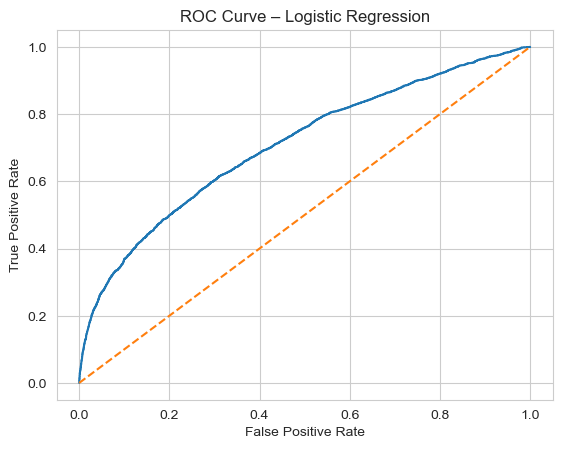

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y, probs_logit)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve – Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


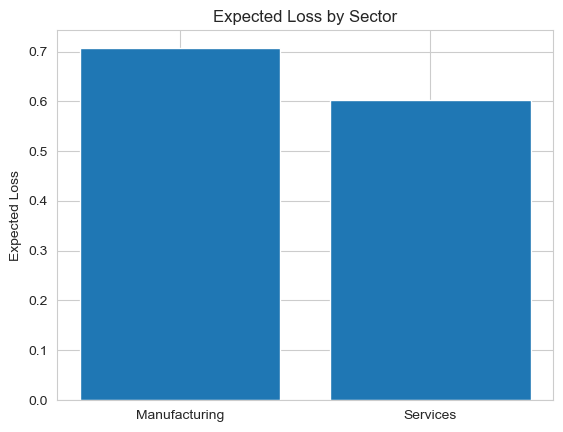

In [59]:
plt.bar(["Manufacturing", "Services"], [loss_man, loss_serv])
plt.title("Expected Loss by Sector")
plt.ylabel("Expected Loss")
plt.show()


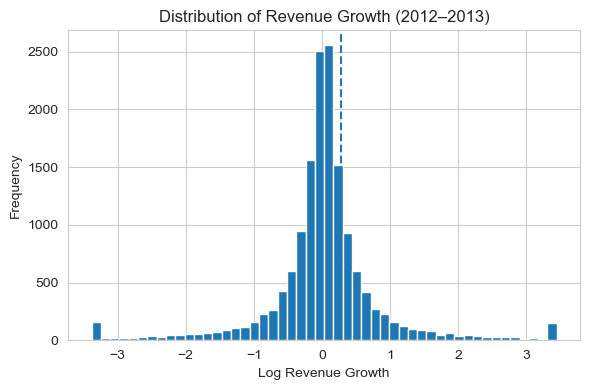

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(model_final['log_growth_w'], bins=50)
plt.axvline(model_final['log_growth_w'].quantile(0.75), linestyle='--')
plt.title("Distribution of Revenue Growth (2012–2013)")
plt.xlabel("Log Revenue Growth")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
